<a href="https://colab.research.google.com/github/Loga19818eeanvesh/GenerativeAdversarialNetworks_GANs_Assignments/blob/main/c1w2_GAN_DeepConvolutional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(num_features=output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(num_features=output_channels),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride)
                #### END CODE HERE ####
            )

    '''
    Function for completing a forward pass of the discriminator: Given an image tensor, 
    returns a 1-dimension tensor representing fake/real.
    Parameters:
        image: a flattened image tensor with dimension (im_dim)
    '''
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [5]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.882267371892929, discriminator loss: 0.5472271926701069


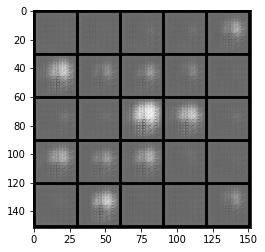

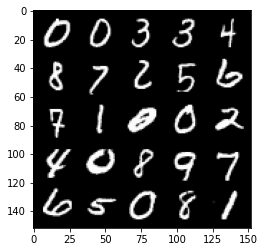

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.6361405583620074, discriminator loss: 0.364716599047184


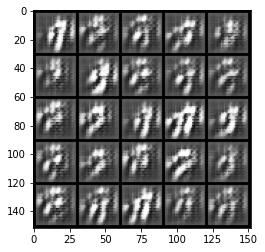

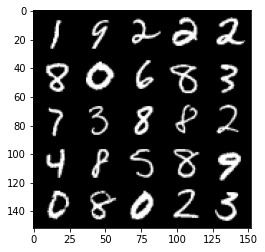

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.3619131236672404, discriminator loss: 0.46410864621400827


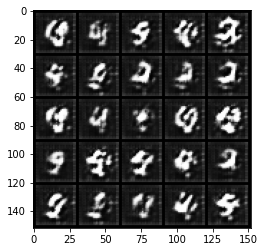

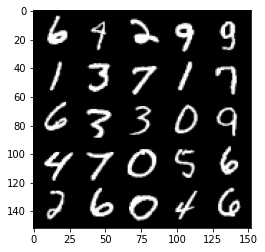

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.022997009307146, discriminator loss: 0.5740378206968313


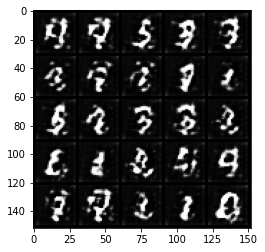

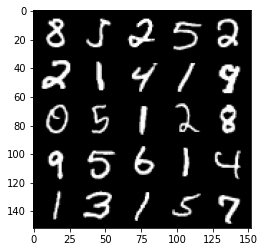

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.8930803168714048, discriminator loss: 0.6008725284337993


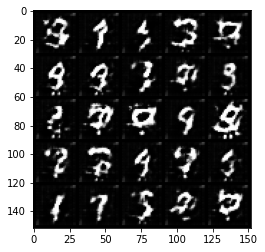

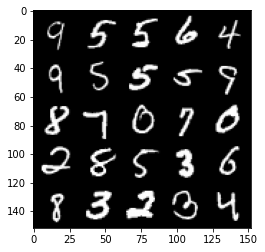

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.8672536472976211, discriminator loss: 0.6245431134700774


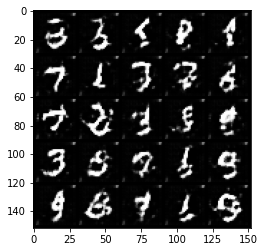

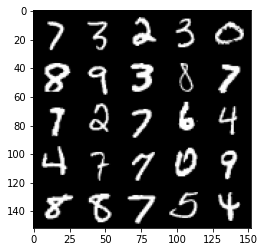

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.8296537992954258, discriminator loss: 0.6381881213188176


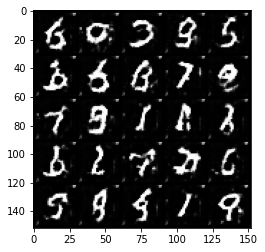

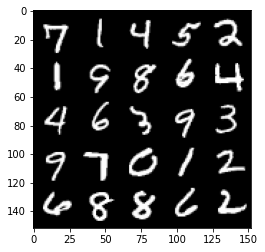

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.7972803906798369, discriminator loss: 0.6476256097555152


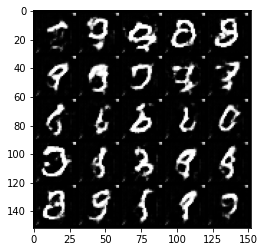

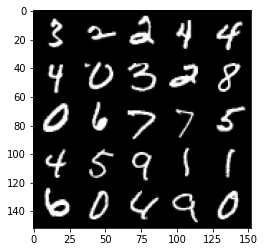

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.7790026828646658, discriminator loss: 0.6670218744277953


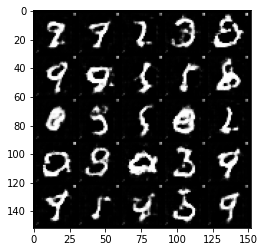

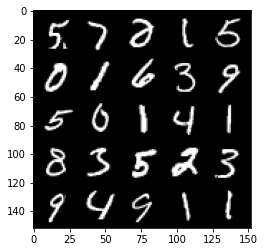

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.7616808165311808, discriminator loss: 0.6751116871833797


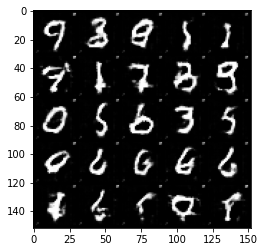

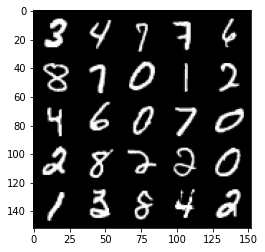

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.7519581167697909, discriminator loss: 0.6786725682020183


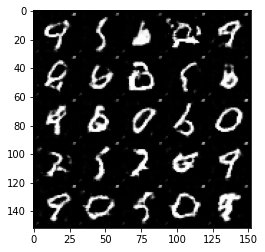

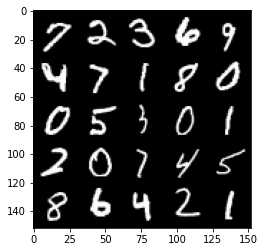

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7520749115347866, discriminator loss: 0.6789494532346724


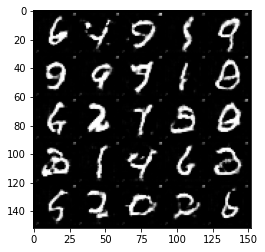

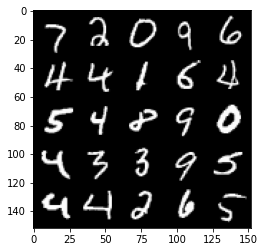

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7426164566278453, discriminator loss: 0.6820437204837813


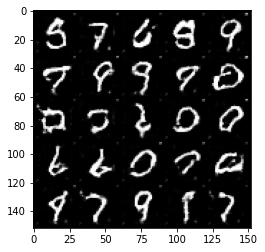

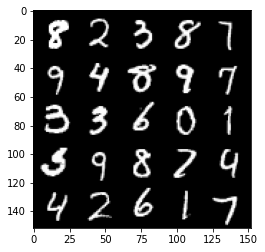

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7340708374977105, discriminator loss: 0.6835489026308058


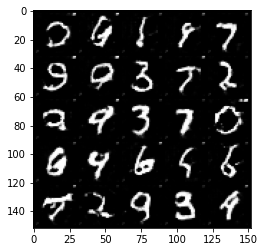

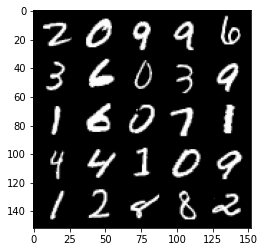

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.731452808320522, discriminator loss: 0.6852865936756128


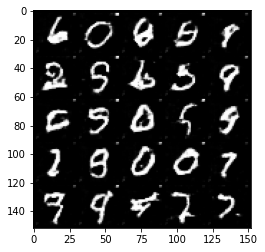

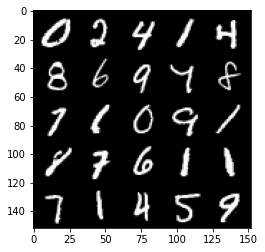

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7277055455446242, discriminator loss: 0.6877618356943129


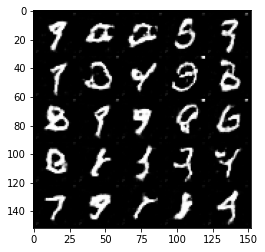

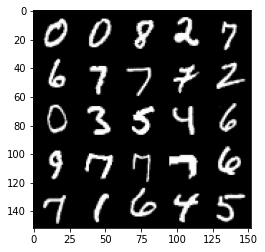

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7266466848850258, discriminator loss: 0.6882416985034938


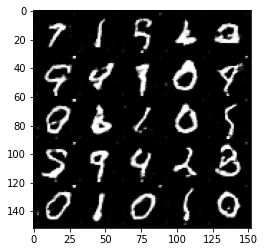

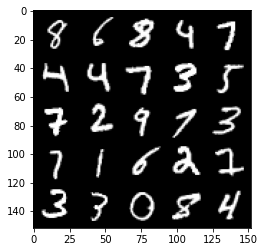

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7252847938537612, discriminator loss: 0.6878673701286312


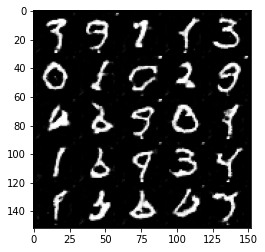

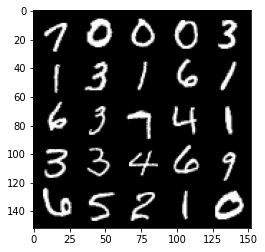

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.722756816983223, discriminator loss: 0.6903188824653623


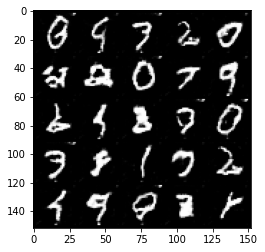

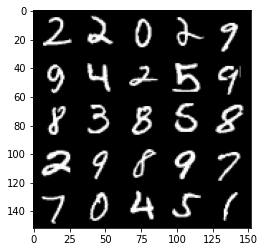

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7227667468786244, discriminator loss: 0.6894921996593476


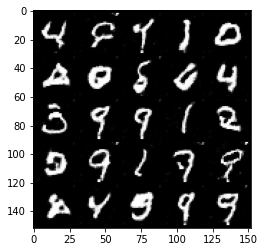

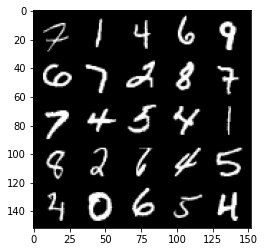

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7199234637022025, discriminator loss: 0.6896488707065579


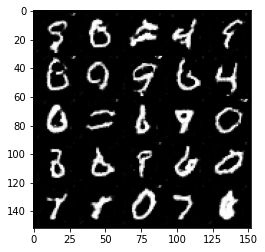

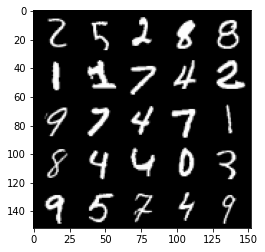

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.7170604990720744, discriminator loss: 0.6915636307001105


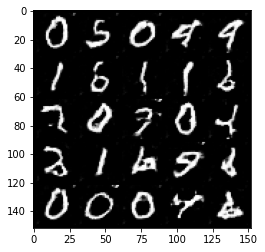

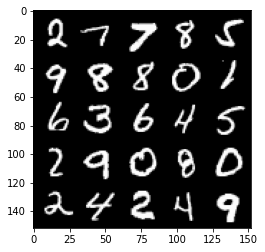

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.7129795723557478, discriminator loss: 0.6933652976751327


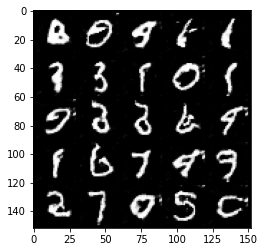

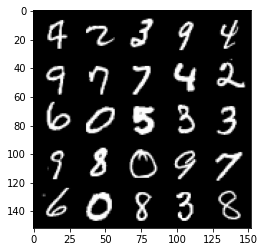

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.712174088299275, discriminator loss: 0.693026485443115


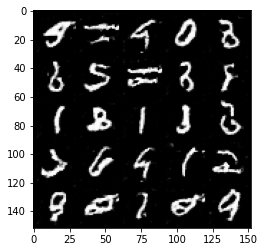

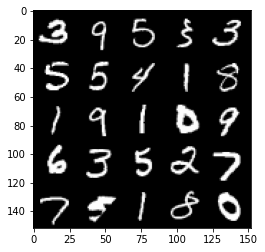

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.7120841263532637, discriminator loss: 0.6936834267377853


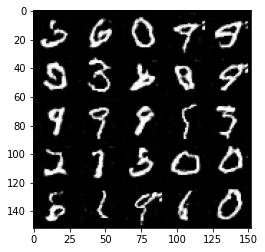

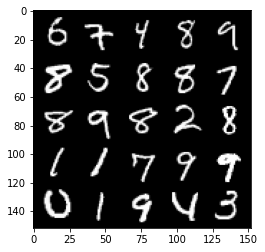

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.7123447511792185, discriminator loss: 0.6936821337938318


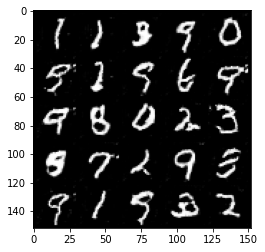

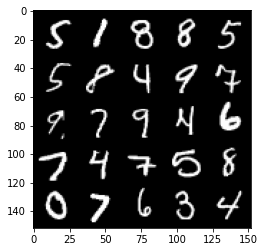

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7104239073395728, discriminator loss: 0.6943845512866975


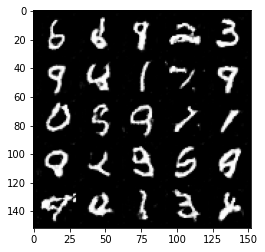

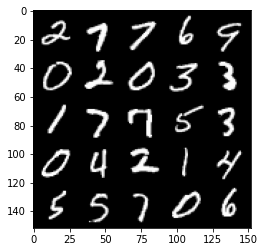

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.7131061124801639, discriminator loss: 0.6946968772411355


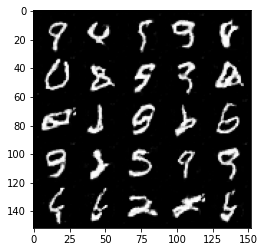

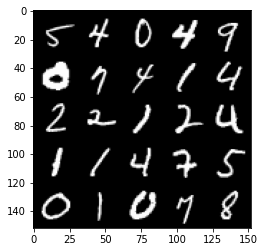

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.7080620105266573, discriminator loss: 0.6944772608280185


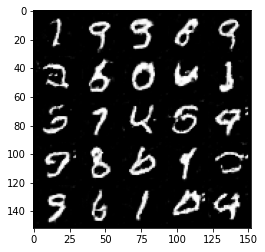

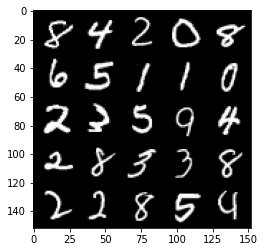

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.7077917436361312, discriminator loss: 0.6954856172800071


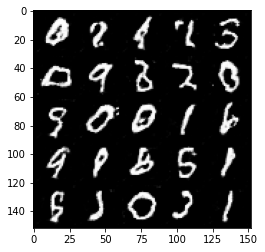

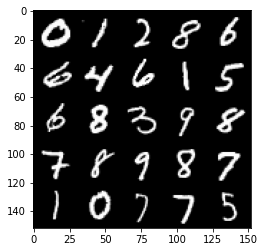

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.7060520903468133, discriminator loss: 0.6948710942268372


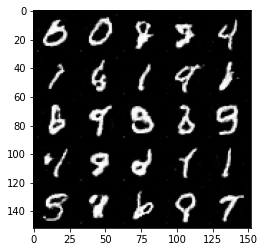

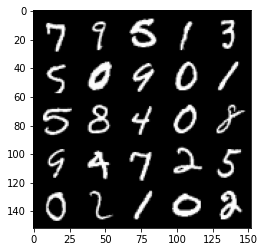

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.7032819062471388, discriminator loss: 0.6960394321680061


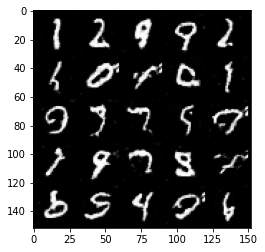

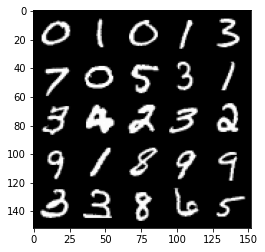

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.7037142992019649, discriminator loss: 0.6960253114700311


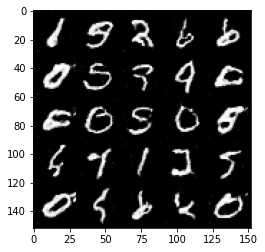

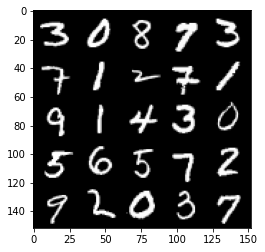

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.7039910689592357, discriminator loss: 0.6959015631675715


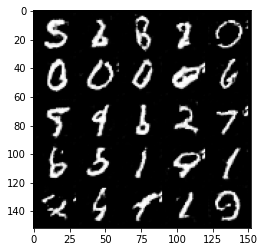

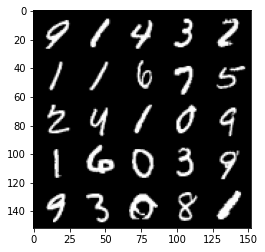

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.7035214772224427, discriminator loss: 0.6958985394239424


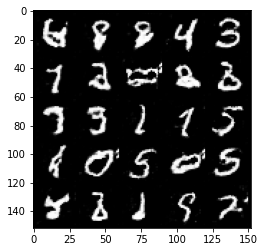

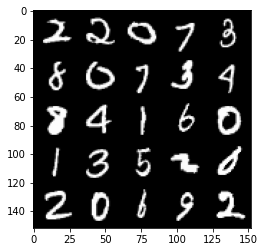

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.7022549573183048, discriminator loss: 0.6952393312454221


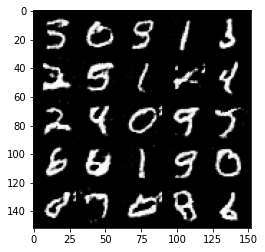

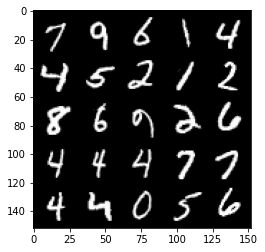

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.7035625489950182, discriminator loss: 0.6956742006540307


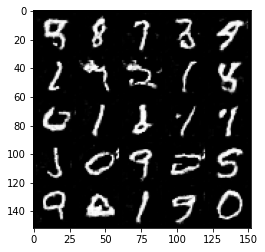

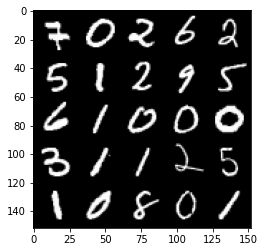

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.7028426057100298, discriminator loss: 0.6953666331768034


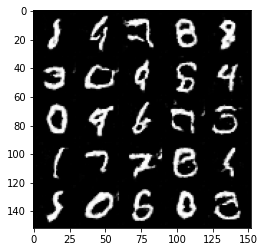

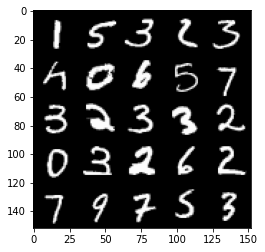

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.7020837262272841, discriminator loss: 0.6961683362722394


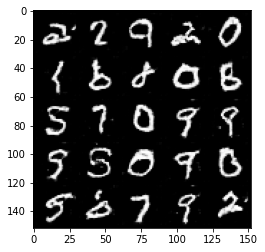

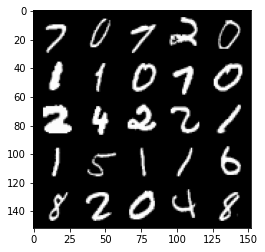

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.7008071877956393, discriminator loss: 0.6947630431652068


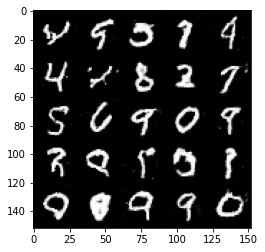

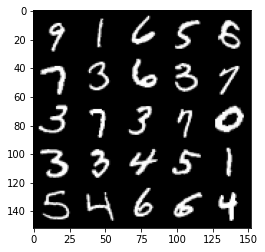

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.7026140530109412, discriminator loss: 0.6946695636510852


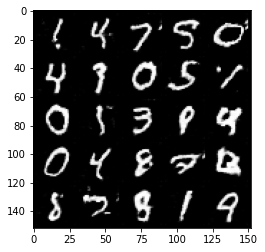

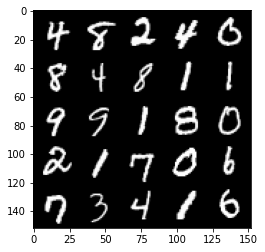

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6991863282918936, discriminator loss: 0.6961594521999362


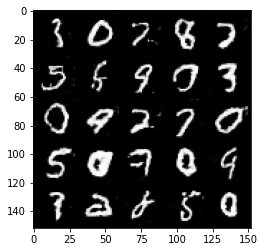

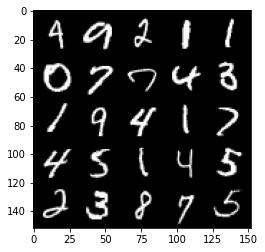

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.6964732935428614, discriminator loss: 0.6962055288553232


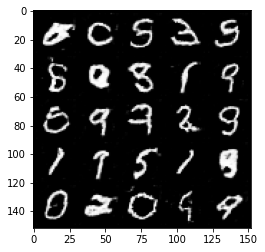

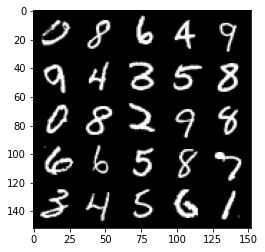

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.6986143054962163, discriminator loss: 0.6954159945249553


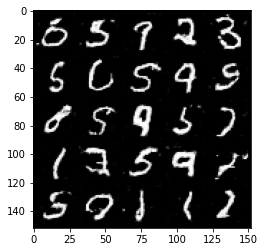

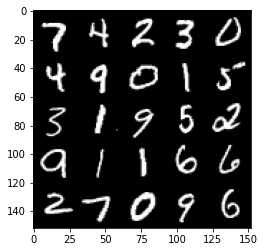

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.6998038874864577, discriminator loss: 0.6946356203556058


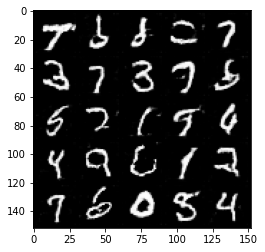

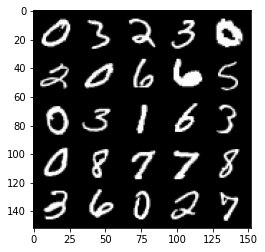

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.698699081897736, discriminator loss: 0.6952345329523084


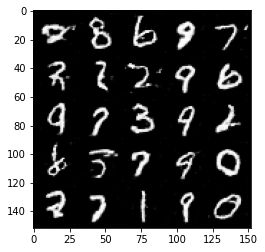

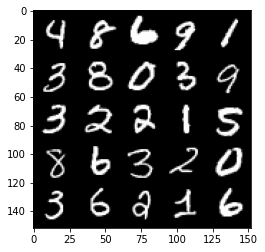

In [7]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1